# Starting :

In [67]:
import re
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy
#pipe
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
#Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
#Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, make_scorer

pd.set_option('display.max_columns', None)

Loading the data :

In [68]:
all_data = pd.read_csv("train_ml.csv", index_col=0)

all_data_final = pd.read_csv("test_ml.csv", index_col=0)mean_squared_error

In [69]:
all_data.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social
count,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39660.000000,3.967100e+04,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000
mean,0.378967,0.002974,9.806332,36.731088,0.395755,0.102317,51.442032,2.321781e+05,0.362406,0.809609,0.199768,0.155807,0.008293,0.002521,0.003832,0.100955
std,2.530353,0.054458,440.393286,144.379127,0.489018,0.303068,34.142227,2.251044e+06,0.480701,0.392614,0.399831,0.362676,0.090690,0.050144,0.061781,0.301273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.500000,0.000000,0.000000,31.000000,4.903000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,43.000000,2.000500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,9.000000,47.000000,1.000000,0.000000,63.000000,4.800100e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,155.000000,1.000000,83480.000000,21540.000000,1.000000,1.000000,528.000000,7.438108e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Extract the important tlds and orgs, with this information, we will know from the beggining what is the information that we have to focus on

In [70]:
def tlds_extraction(data):
    tlds = {}
    X = deepcopy(data)
    X.tld = X.tld.apply(str)
    for word in X.tld:
        processed = word.lower().strip().split('.')
        for w in processed :
            tlds[w] = 1        
    return tlds

def orgs_extraction(data):
    orgs = {}
    X = deepcopy(data)
    X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
    for org in X.org :
        orgs[org] = 1
    return orgs

imp_tlds = set(tlds_extraction(all_data_final))
imp_orgs = set(orgs_extraction(all_data_final))

# Lets create more features :

In [71]:
all_data["sub/body"] = all_data.chars_in_subject / all_data.chars_in_body
all_data["urls/body"] = all_data.urls/all_data.chars_in_body
all_data["images/body"] = all_data.images/all_data.chars_in_body
all_data["salutaions&designation"] = all_data.salutations*all_data.designation

all_data_final["sub/body"] = all_data_final.chars_in_subject / all_data_final.chars_in_body
all_data_final["urls/body"] = all_data_final.urls/all_data_final.chars_in_body
all_data_final["images/body"] = all_data_final.images/all_data_final.chars_in_body
all_data_final["salutaions&designation"] = all_data_final.salutations*all_data_final.designation


#Lets replace the NAN values
all_data = all_data.fillna(value=0)
all_data_final = all_data_final.fillna(value=0)

<AxesSubplot:>

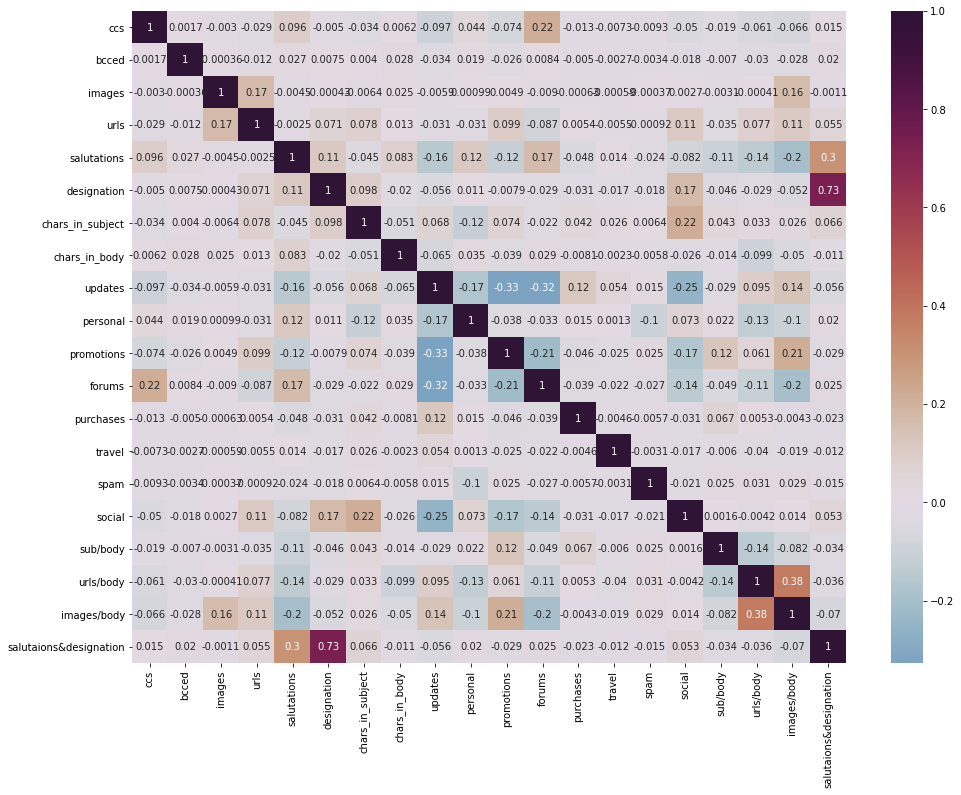

In [72]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(all_data.corr(),cmap = "twilight_shifted", annot=True, ax=ax, center=0)

### Date formatting and encoding

In [73]:
def format_date(row):
    pattern = r'(\d{1,2}.*\d{2}:\d{2}:\d{2}) ([+-]\d{2}\d{2})'
    
    ans = re.search(pattern, string=row)
    
    if ans:
        if ans.group(1)[1] == ' ':
            return ''.join(['0', ans.group(1), ans.group(2)])
        else:
            return ''.join([ans.group(1), ans.group(2)])
    else:
        return "08 Oct 1999 00:00:00+2020"

#The for loops are slow :
class DateEncoder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        X = deepcopy(data)
        X['date'] = pd.to_datetime(X['date'].apply(format_date))
        tmp_1 = []
        tmp_2 = []
        tmp_3 = []
        tmp_4 = []
        tmp_5 = []
        tmp_6 = []
        tmp_7 = []

        for d in X['date']:
            tmp_1.append(int(d.strftime("%w")))
            tmp_2.append(int(d.strftime("%H")))
            tmp_3.append(int(d.strftime("%m")))
            tmp_4.append(int(d.strftime("%y")))
            tmp_5.append(d.strftime("%z"))
            tmp_6.append(int(d.strftime("%d")))
            tmp_7.append(int(d.strftime("%M")))

        X['date_dayweek'] = tmp_1
        X['date_hour'] = tmp_2
        X['date_month'] = tmp_3
        X['date_year'] = tmp_4
        X['date_timezone'] = tmp_5
        X['date_daymonth'] = tmp_6
        X['date_minutes'] = tmp_7

        
        X = X.drop(columns=['date'])

        return X

date_column_transformer = make_column_transformer((OneHotEncoder(sparse=0, handle_unknown='ignore'), ['date_timezone']), remainder="passthrough")
date_pipe = make_pipeline(DateEncoder(), date_column_transformer)

### Mailtype cleaning and encoder 

For training data

In [74]:
class MailTypeEncoder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        X = deepcopy(data)

        multipart = []
        alternative = []
        text = []
        mixed = []
        signed = []
        html = []
        plain = []
        calendar = []
        related = []
        report = []

        for mtype in X.mail_type.values :
            mtype = str(mtype)
            multipart.append( "multipart" in mtype.lower())
            alternative.append( "alternative" in mtype.lower())
            text.append( "text" in mtype.lower())
            mixed.append( "mixed" in mtype.lower())
            signed.append( "signed" in mtype.lower())
            html.append( "html" in mtype.lower())
            plain.append( "plain" in mtype.lower())
            calendar.append( "calendar" in mtype.lower())
            related.append( "related" in mtype.lower())
            report.append( "report" in mtype.lower())

        #Encoding
        X["multipart"] = multipart
        X["alternative"] = alternative
        X["text"] = text
        X["mixed"] = mixed
        X["signed"] = signed
        X["html"] = html
        X["plain"] = plain
        X["calendar"] = calendar
        X["related"] = related
        X["report"] = report
        
        X = X.drop(columns=['mail_type'])
        
        return X

For test data

### TLD cleaning and encoding

Tlds are encoder in a different way than a simple OneHotEncoder, we first extract words separated by "." then we encode the existence of the extracted words in each tld.

for example :
    `hello.com` will have 1 in the column `hello` and 1 in the column `com`
    
We also encode the length and some other informations about each tld

In [75]:
class TldEncoder(BaseEstimator):
    def __init__(self, MINIMAL_REPEAT_TLDS=3, only_imp = True):
        self.MINIMAL_REPEAT_TLDS = MINIMAL_REPEAT_TLDS
        self.tlds = {} #We will use a dictionary counting the number of occurance of each tld name
        self.only_imp = only_imp
    def fit(self, data, y=None):
        self.tlds = {} #initialisation
        X = deepcopy(data)
        X.tld = X.tld.apply(str)
        
        for word in X.tld :
            processed = word.lower().strip().split('.')
            for w in processed :
                try :
                    self.tlds[w] += 1
                except: #w is not yet in the dictionary 
                    self.tlds[w] = 1
        tlds = deepcopy(self.tlds)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in tlds:
                if word not in imp_tlds:
                    del(self.tlds[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)        
        X.tld = X.tld.apply(str)
        
        tlds_columns_names = { word : None  for word in filter(lambda x: self.tlds[x]>=self.MINIMAL_REPEAT_TLDS ,self.tlds)}
        tlds_columns = {"tld_" + word : [0]*len(X) for word in tlds_columns_names.keys()}
        tlds_columns["tld_depth"] = [0]*len(X)
        tlds_columns["tld_length"] = [0]*len(X)
        tlds_columns["tld_is_composed"] = [0]*len(X)
        tlds_columns["tld_nums"] = [0]*len(X)


        nums = set("123456789")
        for i,tld in enumerate(X.tld) :
            tlds_columns["tld_depth"][i] = tld.count(".")
            tlds_columns["tld_length"][i] = len(tld)
            tlds_columns["tld_is_composed"][i] = '-' in tld
            tlds_columns["tld_nums"][i] = len(nums.intersection(tld))


            for word in tlds_columns_names.keys() :
                if word in tld.lower():
                    tlds_columns["tld_"+word][i] = 1
        
        X[list(tlds_columns.keys())] = np.array(list(tlds_columns.values())).transpose()
        
        X = X.drop(columns=['tld'])
        
        return X

### ORG cleaning and encoding

This encoding is nearly the same as OneHotEncoding, but it does implement more features like the length of each organisation name

In [76]:
class OrgEncoder(BaseEstimator):
    def __init__(self, MINIMAL_REPEAT_ORGS = 2, only_imp=True):
        self.MINIMAL_REPEAT_ORGS = MINIMAL_REPEAT_ORGS
        self.orgs = {}
        self.only_imp = only_imp
    def fit(self, data, y=None):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        for org in X.org :
            try:
                self.orgs[org] += 1
            except:
                self.orgs[org] = 1
                
        orgs = deepcopy(self.orgs)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in orgs:
                if word not in imp_orgs:
                    del(self.orgs[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)
        original_org = X.org.apply(str).values
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        orgs_columns_names = { word : None     for word in filter(lambda x: self.orgs[x]>=self.MINIMAL_REPEAT_ORGS,self.orgs)} 
        orgs_columns = { 'org_'+ word : [0]*len(X)     for word in orgs_columns_names.keys()} 
        orgs_columns["org_length"] = [0]*len(X)
        orgs_columns["org_is_composed"] = [0]*len(X)
        orgs_columns["org_nums"] = [0]*len(X)
        
        nums = set('123456789')
        for i,org in enumerate(X.org) :
            orgs_columns["org_length"][i] = len(org)
            orgs_columns["org_is_composed"][i] = '-' in original_org[i]
            orgs_columns["org_nums"][i] = len(nums.intersection(org))
            for word in orgs_columns_names.keys() :
                if word == org.lower():
                    orgs_columns["org_"+word][i] = 1
        #Columns creation
        X[list(orgs_columns.keys())] = np.array(list(orgs_columns.values())).transpose()
        
        X = X.drop(columns=['org'])

        return X
    


class OrgEncoder2(BaseEstimator):
    '''
    This encoder is not the main one, the goal behind was to create less
    encoding features by encoding all the organisations only by an id in one column
    '''
    def __init__(self, MINIMAL_REPEAT_ORGS = 2, only_imp = True):
        self.MINIMAL_REPEAT_ORGS = MINIMAL_REPEAT_ORGS
        self.orgs = {}
        self.only_imp = only_imp
    def fit(self, data, y=None):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        for org in X.org :
            try:
                self.orgs[org] += 1
            except:
                self.orgs[org] = 1
        orgs = deepcopy(self.orgs)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in orgs:
                if word not in imp_orgs:
                    del(self.orgs[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        orgs_columns_names = [word  for word in filter(lambda x: self.orgs[x]>=self.MINIMAL_REPEAT_ORGS,self.orgs)]
        orgs_length = []
        column = [0]*len(X)
        
        for i,org in enumerate(X.org) :
            orgs_length.append(len(org))
            for j in range(len(orgs_columns_names)) :
                if orgs_columns_names[j] == org.lower():
                    column[i] = j+1
        #Columns creation
        X["orgs"] = column
        X["orgs_length"] = orgs_length
        
        X = X.drop(columns=['org'])

        return X


# Model building 

We noticed that our model building was not optimized like a OneHot, it take more than 1 minutes to juste generate our features. Therefore we prefered to execute our pipeline here :

In [19]:
transformations = make_column_transformer((date_pipe, ['date']),
                                (MailTypeEncoder(), ['mail_type']),
                                (TldEncoder(MINIMAL_REPEAT_TLDS = 13, only_imp = True), ['tld']),
                                (OrgEncoder(MINIMAL_REPEAT_ORGS = 2, only_imp = True), ['org']),
                                remainder="passthrough")
model = make_pipeline(transformations, RandomForestClassifier()) # This would be used if we wanted to fine tune MINIMAL_REPEAT_TLDS and MINIMAL_REPEAT_ORGS

In [22]:
transformations.fit(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))

X = transformations.transform(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))
X_final = transformations.transform(all_data_final)
y = all_data[['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']]

### Easy Fine Tuning : (Takes about 1h30 min)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [27]:
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']
grids = []
loss = []

for label in labels:
    print("For : " +label+" ...")
    #grid_params = {'base_estimator' : [DecisionTreeClassifier(max_depth=i) for i in [3,4,5]], 'n_estimators': range(20,201,30)}
    #grid_params = {'C':np.logspace(-1,1,3), 'gamma': np.logspace(2,4,3)}
    #grid_params = {'base_estimator' : [MLPClassifier(hidden_layer_sizes=[i,j,z],max_iter=20) for i in [20,40] for j in [10,20] for z in [10,20] ], 'n_estimators': range(20,81,30)}
    grid_params = {'n_estimators': [250,350], 'criterion': ['entropy'], 'max_features':[0.1,0.4,0.5,0.2]}
    #grid_params = {'n_estimators': range(2,5,1)}
    grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_params, cv=2, verbose=1, scoring=make_scorer(log_loss,greater_is_better=0), n_jobs=8, return_train_score=True, refit=True)
    #grid = GridSearchCV(estimator=AdaBoostClassifier(RandomForestClassifier(n_estimators=150, max_features=100)), param_grid=grid_params, cv=3, verbose=1, scoring=make_scorer(log_loss,greater_is_better=0), n_jobs=2, return_train_score=True, refit=True)
    grid.fit(x_train, y_train[label])

    print("Best classifier : ", grid.best_estimator_ )
    print(classification_report(y_test[label], grid.best_estimator_.predict(x_test)))
    loss.append(log_loss(y_test[label], grid.best_estimator_.predict_proba(x_test)))
    print(loss[-1])
    grids.append(grid)
print("\n \nMean loss = ",np.mean(loss))

For : updates ...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.2, n_estimators=350)
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5059
           1       0.92      0.92      0.92      2876

    accuracy                           0.94      7935
   macro avg       0.94      0.94      0.94      7935
weighted avg       0.94      0.94      0.94      7935

0.16733394677910352
For : personal ...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.4, n_estimators=350)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1511
           1       0.99      0.99      0.99      6424

    accuracy                           0.98      7935
   macro avg       0.97      0.97      0.97      7935
weighted avg       0.98   

In [28]:
#This is just to test the effect of the  *0.9999+0.00005 methode
print(log_loss(y_test["updates"], grids[0].best_estimator_.predict_proba(x_test)))
print(log_loss(y_test["updates"], grids[0].best_estimator_.predict_proba(x_test) *0.9999+0.00005))

0.16733394677910352
0.1580444901759665


Refit for all data

In [29]:
for i in range(8):
    grids[i].best_estimator_.fit(X,y[labels[i]])
    print(i)

0
1
2
3
4
5
6
7


### Predictions :

In [31]:
predictions = pd.DataFrame()
for i,label in enumerate(labels):
    predictions[label] = grids[i].best_estimator_.predict_proba(X_final)[:,1]
    
    predictions[label] = np.sin((predictions[label] - 0.5)*np.pi)/2 +0.5 #force our predictions to be more conclusif (far from 0.5)
    

    predictions[label] *= 0.999
    predictions[label] += 0.0005
    
predictions.to_csv("RForest_sample_submission_ml2.csv", index=True, index_label='Id')

In [60]:
predictions.describe()

,updates,personal,promotions,forums,purchases,travel,spam,social
count,17002.000000,17002.000000,17002.000000,17002.000000,17002.000000,17002.000000,17002.000000,17002.000000
mean,0.364240,0.813807,0.195253,0.157512,0.008531,0.003115,0.004310,0.103723
std,0.410825,0.344314,0.334234,0.307838,0.065189,0.033295,0.047149,0.286995
min,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500
25%,0.003622,0.908966,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500
50%,0.103522,0.990134,0.009866,0.000500,0.000500,0.000500,0.000500,0.000500
75%,0.849650,0.999500,0.187812,0.078547,0.000500,0.000500,0.000500,0.006744
max,0.999500,0.999500,0.999500,0.999500,0.999500,0.993256,0.987012,0.999500


# Testing LightGBM

In [34]:
import lightgbm as lgb

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [62]:
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']
loss = []
bsts = []

for lab in labels:
    print("For : " +lab+" ...")
    params = {'num_leaves': 800, "verbose":-1, "objective":"binary", "bagging_fraction":0.95, "bagging_freq":2, "feature_fraction":0.7, "metric":"logloss", "feature_fraction_bynode":0.2,
              "cegb_tradeoff":1}
    num_round = 100
    
    train_data = lgb.Dataset(x_train, label=y_train[lab])

    bst = lgb.train(params, train_data, num_round)

    print(classification_report(y_test[lab], list(map( round, bst.predict(x_test) ))  ))
    loss.append(log_loss(y_test[lab], bst.predict(x_test)))
    print("Train : ",log_loss(y_train[lab], bst.predict(x_train)))
    print("Test : ",loss[-1],"\n")
    bsts.append(bst)
print("\n \nMean loss = ",np.mean(loss))

For : updates ...
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5059
           1       0.92      0.92      0.92      2876

    accuracy                           0.94      7935
   macro avg       0.94      0.94      0.94      7935
weighted avg       0.94      0.94      0.94      7935

Train :  0.018801162068068183
Test :  0.15228167781724175 

For : personal ...
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1511
           1       0.99      0.99      0.99      6424

    accuracy                           0.98      7935
   macro avg       0.97      0.96      0.97      7935
weighted avg       0.98      0.98      0.98      7935

Train :  0.0033188396837178563
Test :  0.0630423345801899 

For : promotions ...
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6349
           1       0.90      0.86      0.88      1586

    

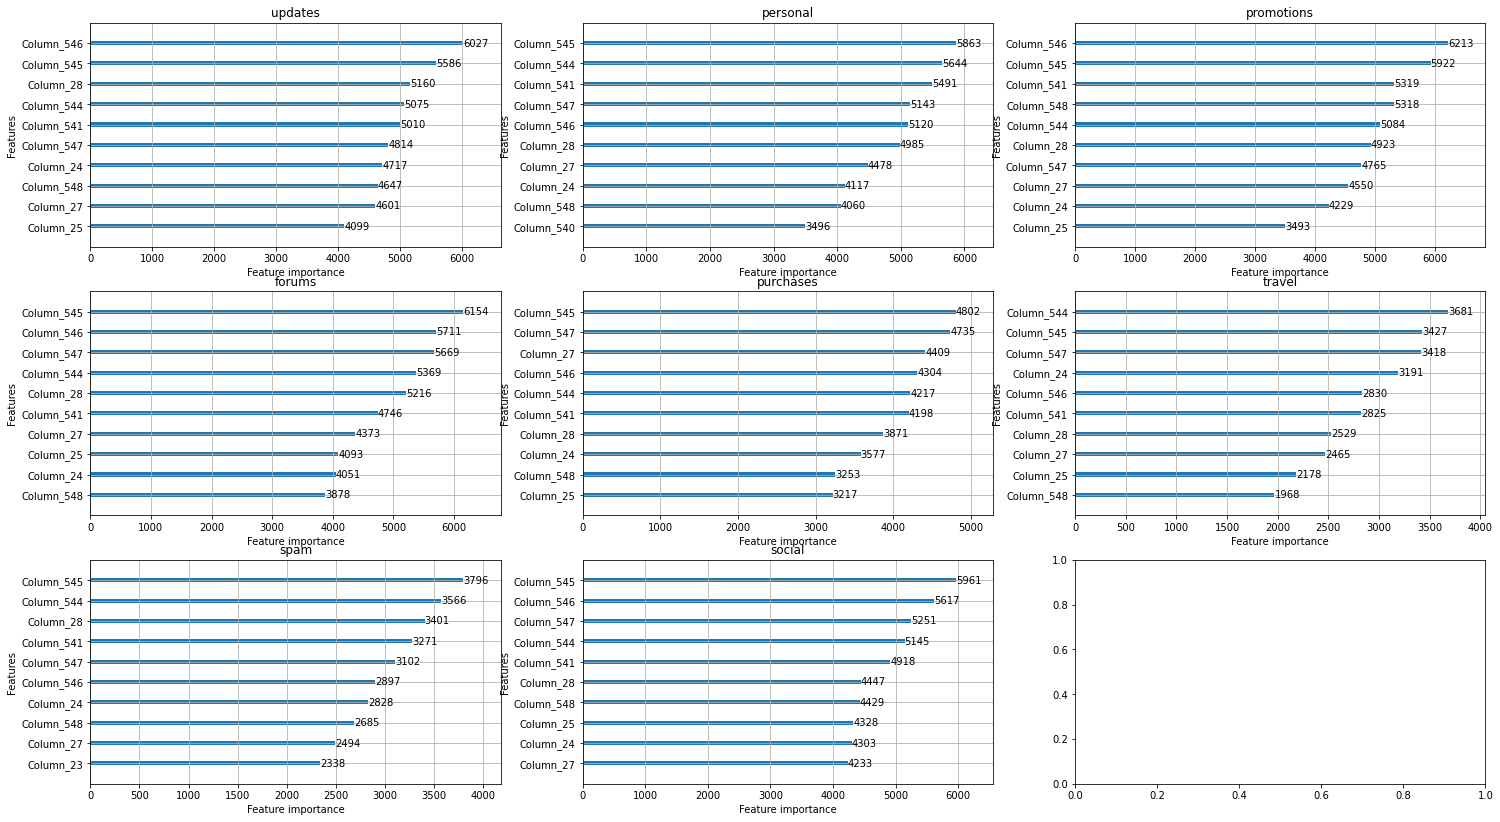

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25,14))
ax = ax.flatten()
for i,bst in enumerate(bsts):
    lgb.plot_importance(bst, ax = ax[i], max_num_features = 10 , title = labels[i])
plt.show()

In [64]:
print(log_loss(y_test["social"], bsts[7].predict(x_test)))
print(log_loss(y_test["social"], bsts[7].predict(x_test) *0.999+0.0005))

0.01341806130251559
0.013487855057464495


In [66]:
for i in range(8):
    train_data = lgb.Dataset(X, label=y[labels[i]])
    bsts[i] = lgb.train(params, train_data, num_round)

In [180]:
predictions = pd.DataFrame()
for i,label in enumerate(labels):
    predictions[label] = bsts[i].predict(X_final)
    predictions[label] *= 0.999
    predictions[label] += 0.0005
    
predictions.to_csv("LGBM_sample_submission_ml.csv", index=True, index_label='Id')

In [349]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,10.0,18.0,15.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [351]:
all_data

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social,sub/body,urls/body,images/body,salutaions&designation
0,"Mon, 15 Oct 2018 08:03:09 +0000 (UTC)",researchgatemail,net,0,0,multipart/alternative,4,28,0,1,47.0,25556,0,1,0,0,0,0,0,1,0.001839,0.001096,0.000157,0
1,"Thu, 17 Apr 2014 09:12:33 -0700 (PDT)",no-ip,com,0,0,multipart/alternative,6,32,0,0,46.0,19930,1,1,0,0,0,0,0,0,0.002308,0.001606,0.000301,0
2,"Thu, 27 Oct 2016 01:36:28 +0000",mail,goodreads.com,0,0,multipart/mixed,0,0,0,0,21.0,4,0,1,0,0,0,0,0,1,5.250000,0.000000,0.000000,0
3,"Fri, 16 Oct 2020 08:06:31 +0000 (GMT)",insideapple,apple.com,0,0,multipart/alternative,108,171,0,0,52.0,96568,0,0,1,0,0,0,0,0,0.000538,0.001771,0.001118,0
4,"Thu, 02 Jul 2015 10:16:46 +0000",twitter,com,0,0,multipart/alternative,20,166,0,0,81.0,95131,0,1,0,0,0,0,0,1,0.000851,0.001745,0.000210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39666,"Tue, 08 Oct 2019 18:58:39 +0000",mp1,tripadvisor.com,0,0,text/html,11,31,0,0,32.0,44952,0,0,1,0,0,0,0,0,0.000712,0.000690,0.000245,0
39667,03 Apr 2018 16:07:48 +0530,0,0,0,0,text/plain,0,0,0,0,57.0,721,1,1,0,0,0,0,0,0,0.079057,0.000000,0.000000,0
39668,"Mon, 3 Apr 2017 18:55:47 +0530",iiitd,ac.in,0,0,multipart/alternative,0,0,1,0,28.0,571,0,1,0,1,0,0,0,0,0.049037,0.000000,0.000000,0
39669,"Thu, 14 Jun 2018 00:46:51 +0000",m,mail.coursera.org,0,0,multipart/alternative,27,136,1,1,24.0,92847,1,1,0,0,0,0,0,0,0.000258,0.001465,0.000291,1
